In [4]:
# List of imports
from copy import deepcopy
from datetime import datetime
from functools import *
from itertools import product

import einops
import gc
import jax
import jax.numpy as jnp
import matplotlib
import neural_tangents as nt
import numpy as np
import optax
import os
import pandas as pd
import pickle
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import random as nrandom
import seaborn as sns
import shutil
import sys
import time
import torch
import torch.nn as nn
import torch.optim as optim
from jax import grad, jit, jacfwd, jacrev, lax, random, vmap
from jax.example_libraries import optimizers
from matplotlib import cm, pyplot as plt
from neural_tangents import stax
from pathlib import Path
from scipy.interpolate import BSpline, interp1d, make_interp_spline
from torch import matmul as mm
from torch._C import wait
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from scipy.interpolate import interp1d

In [5]:
cmap = matplotlib.colormaps.get_cmap('tab20')
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
print(jax.devices()) 
device

[CudaDevice(id=0)]


device(type='cuda')

# grokking over time

In [17]:
# Figure 1
D = 100
P = 550
N = 500

def target_fn(beta, X):
    return (X.T @ beta)**2/2.0

X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)

yt = target_fn(beta,Xt)

W = random.normal(random.PRNGKey(0), (N, D))

a = random.normal(random.PRNGKey(0), (N, ))
params = [a, W]
alpha = 1 # scaling parameter, NOT weight norm scale
eps = 0.02

def NN_func2(params,X):
    global alpha
    global eps

    a, W = params
    D = W.shape[1]
    N = a.shape[0]
    h = W @ X.T

    f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts
    return f


def phi(z, eps = 0.25):
        return z + 0.5*eps*z**2

In [18]:
def kernel_regression(X, y, Xt, yt, params, which='test'):
    K_train = ntk_fn(X.T, None, params)
    
    a = jnp.linalg.solve(K_train, y)

    if which=="test":
        k_test_train = ntk_fn(Xt.T, X.T, params)
    else:
        k_test_train = ntk_fn(X.T, X.T, params)
    k_test_train_squeezed = jnp.squeeze(k_test_train)
    estimates= jnp.dot(k_test_train_squeezed, a)
    labels = yt if which=='test' else y
    mse = jnp.mean((estimates - labels) ** 2)
    return mse


def kalignment(K, train_y):
    # alignment with optimal K
    train_yc = train_y.reshape(-1, 1)
    train_yc = train_yc - train_yc.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

def kalignment_rela(K, K0):
    # alignment with limiting intialized 
    Kc = K - K.mean(axis=0)
    Kc0 = K0 - K0.mean(axis=0)
    top = jnp.dot(Kc, Kc0)
    bottom = jnp.linalg.norm(Kc) * jnp.linalg.norm(Kc0)
    return jnp.trace(top)/bottom

def kdiff(K, K0):
    return jnp.linalg.norm(K-K0)

def frobenius(K, K0):
    x = K-K0
    eigenval, eigenvec = jax.numpy.linalg.eigh(x)
    frobenius_norm = jnp.sqrt(np.sum(eigenval**2))
    return frobenius_norm

In [19]:
ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=())


kmse = kernel_regression(X, y, Xt, yt, params)
kmse_train = kernel_regression(X, y, Xt, yt, params, which='train')
K_train0 = ntk_fn(X.T, None, params)
K_test0 = ntk_fn(Xt.T, None, params)

 50%|██████████▉           | 49901/100001 [01:19<01:06, 749.14it/s]

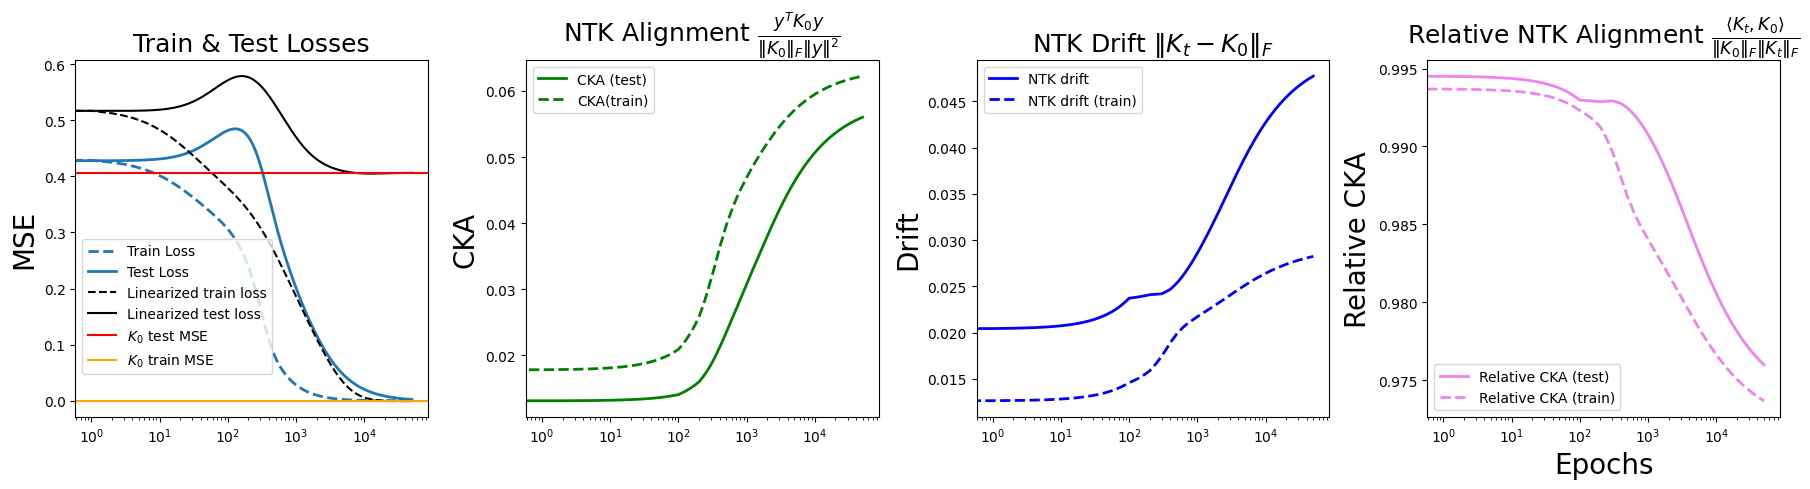

100%|█████████████████████▉| 99901/100001 [02:39<00:00, 715.45it/s]

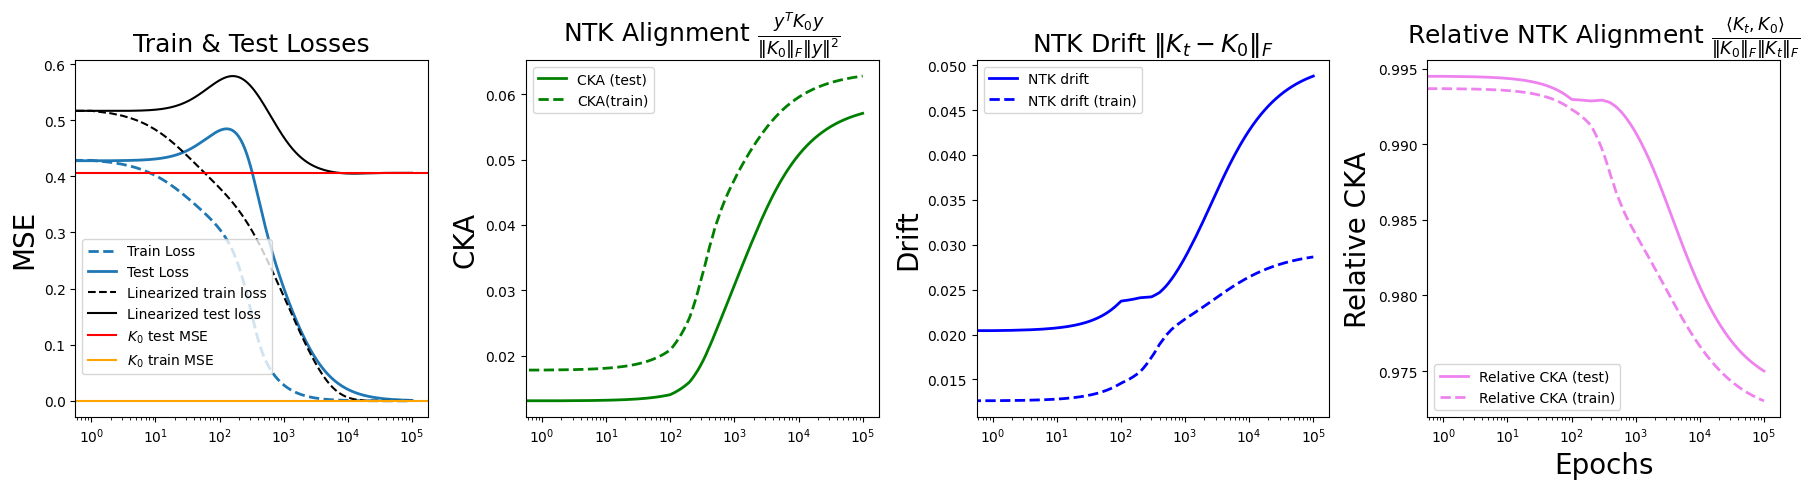

100%|█████████████████████| 100001/100001 [02:44<00:00, 608.96it/s]


In [13]:
alphas = [1]
epsilons = [0.25]
epochs = 100000
# epochs = 10000
CENTER_LOSS = False
TRAIN_READOUTS = False
ntk_interval = 100


for alpha in alphas:
  for eps in epsilons:
    kaligns_test = []
    kaligns_rela_test = []
    kdiff_test = []
    kaligns_train = []
    kaligns_rela_train = []
    kdiff_train = []
    epochs_to_plot = []
    dots = []

    Cs, As = [], []
    actual_w1aligns, actual_w2aligns = [], []
    w1_aligns, w2_aligns = [], []
    w1_vars, w2_vars, ws_covs = [], [], []
    vars_compute_interval = 50

    lamb = 0
    eta = N/alpha**2
    opt_init, opt_update, get_params = optimizers.sgd(eta)
    opt_init_lin, opt_update_lin, get_params_lin = optimizers.sgd(eta)

    opt_state = opt_init(params)
    opt_state_lin = opt_init_lin(params)

    f_lin = nt.linearize(NN_func2, params)
    lin_tr_losses = []
    lin_te_losses = []


    if CENTER_LOSS:
      loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T)- NN_func2(params,X.T) - y )**2))
    else:
      loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T) - y )**2 / alpha**2 ))

    f_lin0 = nt.linearize(NN_func2, params)
    lin_loss = jit(lambda p, X, y: jnp.mean((f_lin(p, X.T) - f_lin0(params, X.T) - y)**2)  )
    grad_loss_lin = jit(grad(lin_loss, 0))

    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []

    alignments, alignmentst = [], []
    epochs_to_plot = []

    t1s, t2s, t3s, epochs_to_compute = [], [], [], []
    t1sm, t2sm, t3sm, ts_summ = [], [], [], []
    ts_sum = []
    alignments, alignmentst = [], []

    kmse = kernel_regression(X, y, Xt, yt, get_params(opt_state))

    for t in tqdm(range(epochs+1)):
      pars = get_params(opt_state)

      train_loss = loss_fn(pars, X, y)
      test_loss = loss_fn(pars, Xt, yt)
      tr_losses += [train_loss]
      te_losses += [test_loss]

      # new update rule for f_lin to compare learning curves
      lin_pars = get_params_lin(opt_state_lin)
      opt_state_lin = opt_update_lin(t, grad_loss_lin(lin_pars, X, y), opt_state_lin)

      lin_tr_losses += [ lin_loss(lin_pars, X, y) ]
      lin_te_losses += [ lin_loss(lin_pars, Xt, yt) ]

      if t % vars_compute_interval == 0:
          epochs_to_compute.append(t)
      if t % ntk_interval == 0 and t>0:
        K_test = ntk_fn(Xt.T, None, pars)
        cka_test = kalignment(K_test, yt)
        kaligns_rela_test += [kalignment_rela(K_test, K_test0)]
        # kaligns_rela_test += [frobenius(K_test, K_test0)]
        kdiff_test += [kdiff(K_test, K_test0)]
        kaligns_test += [ cka_test ]

        K_train = ntk_fn(X.T, None, pars)
        cka_train = kalignment(K_train, y)
        kaligns_rela_train += [kalignment_rela(K_train, K_train0)]
        # kaligns_rela_train += [frobenius(K_train, K_train0)]
        kdiff_train += [kdiff(K_train, K_train0)]
        kaligns_train += [ cka_train ]

      opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)


      if t % 50000 == 0 and t>0:
        max_t = t
        t_values = np.arange(0, max_t, ntk_interval)
        interpolator = interp1d(t_values, kaligns_test, kind='linear', fill_value='extrapolate')
        interpolator1 = interp1d(t_values, kaligns_rela_test, kind='linear', fill_value='extrapolate')
        interpolator2 = interp1d(t_values, kdiff_test, kind='linear', fill_value='extrapolate')
        interpolated_kaligns_test = interpolator(np.arange(max_t))
        interpolated_kaligns_rela_test = interpolator1(np.arange(max_t))
        interpolated_kdiff_test = interpolator2(np.arange(max_t))

        interpolator = interp1d(t_values, kaligns_train, kind='linear', fill_value='extrapolate')
        interpolator1 = interp1d(t_values, kaligns_rela_train, kind='linear', fill_value='extrapolate')
        interpolator2 = interp1d(t_values, kdiff_train, kind='linear', fill_value='extrapolate')
        interpolated_kaligns_train = interpolator(np.arange(max_t))
        interpolated_kaligns_rela_train = interpolator1(np.arange(max_t))
        interpolated_kdiff_train = interpolator2(np.arange(max_t))


        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(18, 5), sharex=False)

        # 1) MSE losses
        col = cmap(0)
        ax1.plot(np.array(tr_losses),
                 linestyle='--', label=r'Train Loss',
                 color=col, lw=2)
        ax1.plot(np.array(te_losses),
                 label=r'Test Loss',
                 color=col, lw=2)
        ax1.plot(np.array(lin_tr_losses),
                 color='black', linestyle='--',
                 label='Linearized train loss')
        ax1.plot(np.array(lin_te_losses),
                 color='black',
                 label='Linearized test loss')
        ax1.axhline(kmse,
                    color='r', label=r'$K_0$ test MSE')
        ax1.axhline(kmse_train,
                    color='orange', label=r'$K_0$ train MSE')
        ax1.set_xscale('log')
        ax1.set_ylabel('MSE', fontsize=20)
        ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
        ax1.set_title('Train & Test Losses', fontsize=18)
        
        # 2) NTK alignment
        ax2.plot(interpolated_kaligns_test,
                 linestyle='-', color='green',
                 label=r'CKA (test)', lw=2)
        ax2.plot(interpolated_kaligns_train,
                 linestyle='--', color='green', lw=2,
                 label='CKA(train)')
        ax2.set_xscale('log')
        ax2.set_ylabel('CKA', fontsize=20)
        ax2.legend(loc='upper left')
        ax2.set_title(r'NTK Alignment $\frac{y^T K_0 y}{\|K_0\|_F \|y\|^2}$', fontsize=18)

        # 3) drift: this is the one that looks interesting
        ax3.plot(interpolated_kdiff_test,
                 linestyle='-', color='blue', lw=2,
                 label='NTK drift')
        ax3.plot(interpolated_kdiff_train,
                 linestyle='--', color='blue', lw=2,
                 label='NTK drift (train)')
        ax3.set_xscale('log')
        ax3.set_ylabel('Drift', fontsize=20)
        ax3.legend(loc='upper left')
        ax3.set_title(r'NTK Drift $\|K_t-K_0\|_F$', fontsize=18)
        
        # 3) Relative NTK alignment
        ax4.plot(interpolated_kaligns_rela_test,
                 linestyle='-', color='violet', lw=2,
                 label='Relative CKA (test)')
        ax4.plot(interpolated_kaligns_rela_train,
                 linestyle='--', color='violet', lw=2,
                 label='Relative CKA (train)')
        ax4.set_xscale('log')
        ax4.set_xlabel('Epochs', fontsize=20)
        ax4.set_ylabel('Relative CKA', fontsize=20)
        ax4.legend(loc='lower left')
        ax4.set_title(r'Relative NTK Alignment $\frac{\langle K_t, K_0\rangle}{\|K_0\|_F \|K_t\|_F}$', fontsize=18)
        
        plt.tight_layout()
        plt.savefig('ogexp.pdf')
        plt.show()

## with NTK loss

 50%|██████████▉           | 49951/100001 [01:45<01:45, 475.23it/s]

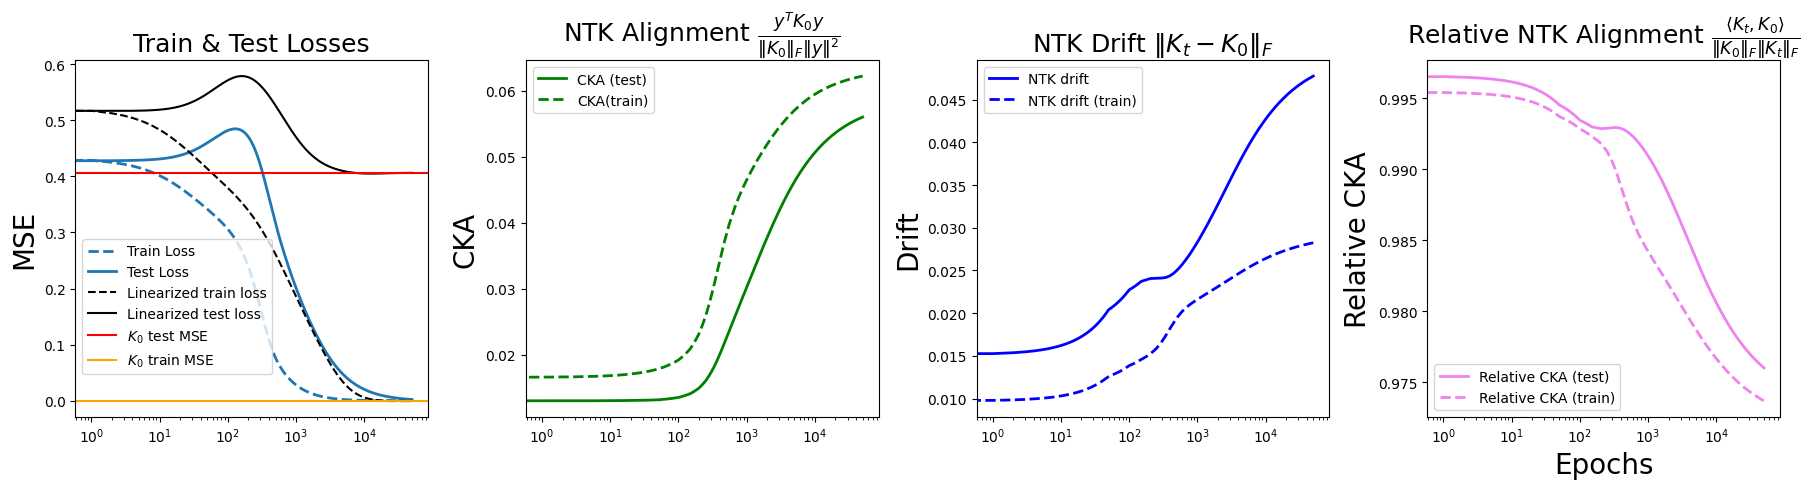

100%|█████████████████████▉| 99952/100001 [03:44<00:00, 462.11it/s]

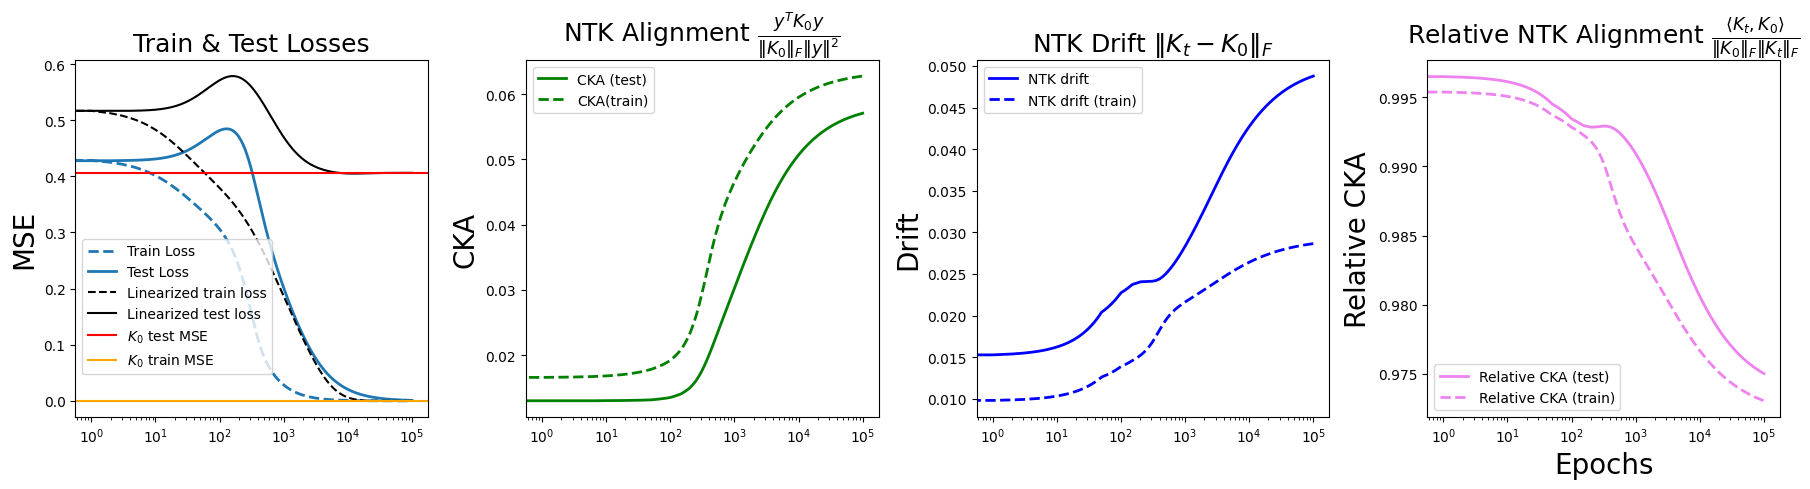

100%|█████████████████████| 100001/100001 [03:59<00:00, 416.69it/s]


In [20]:
alphas = [1]
epsilons = [0.25]
epochs = 100000
# epochs = 10000
CENTER_LOSS = False
# NTK_LOSS = 'align_rela'
NTK_LOSS = 'drift'
TRAIN_READOUTS = False
ntk_interval = 50


for alpha in alphas:
  for eps in epsilons:
    kaligns_test = []
    kaligns_rela_test = []
    kdiff_test = []
    kaligns_train = []
    kaligns_rela_train = []
    kdiff_train = []
    epochs_to_plot = []
    dots = []

    Cs, As = [], []
    actual_w1aligns, actual_w2aligns = [], []
    w1_aligns, w2_aligns = [], []
    w1_vars, w2_vars, ws_covs = [], [], []
    vars_compute_interval = 50

    lamb = 0
    eta = N/alpha**2
    opt_init, opt_update, get_params = optimizers.sgd(eta)
    opt_init_lin, opt_update_lin, get_params_lin = optimizers.sgd(eta)

    opt_state = opt_init(params)
    opt_state_lin = opt_init_lin(params)

    f_lin = nt.linearize(NN_func2, params)
    lin_tr_losses = []
    lin_te_losses = []


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T) - y )**2 / alpha**2 ))
    if NTK_LOSS == 'align_rela':
        kloss_fn = jit(lambda K, K0: kalignment_rela(K, K0))
    elif NTK_LOSS == 'drift':
        kloss_fn = jit(lambda K, K0: - kdiff(K, K0))
    else:
      kloss_fn = None

    f_lin0 = nt.linearize(NN_func2, params)
    lin_loss = jit(lambda p, X, y: jnp.mean((f_lin(p, X.T) - f_lin0(params, X.T) - y)**2)  )
    grad_loss_lin = jit(grad(lin_loss, 0))

    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    kreg_loss = jit(lambda p, X, y, K, K0: reg_loss(p, X, y) + kloss_fn(K, K0))
    kgrad_loss = jit(grad(kreg_loss, 0))

    tr_losses = []
    te_losses = []

    alignments, alignmentst = [], []
    epochs_to_plot = []

    t1s, t2s, t3s, epochs_to_compute = [], [], [], []
    t1sm, t2sm, t3sm, ts_summ = [], [], [], []
    ts_sum = []
    alignments, alignmentst = [], []

    kmse = kernel_regression(X, y, Xt, yt, get_params(opt_state))

    for t in tqdm(range(epochs+1)):
      pars = get_params(opt_state)

      train_loss = loss_fn(pars, X, y)
      test_loss = loss_fn(pars, Xt, yt)
      tr_losses += [train_loss]
      te_losses += [test_loss]

      # new update rule for f_lin to compare learning curves
      lin_pars = get_params_lin(opt_state_lin)
      opt_state_lin = opt_update_lin(t, grad_loss_lin(lin_pars, X, y), opt_state_lin)

      lin_tr_losses += [ lin_loss(lin_pars, X, y) ]
      lin_te_losses += [ lin_loss(lin_pars, Xt, yt) ]

      if t % vars_compute_interval == 0:
          epochs_to_compute.append(t)
      if t % ntk_interval == 0 and t>0:
        K_test = ntk_fn(Xt.T, None, pars)
        cka_test = kalignment(K_test, yt)
        kaligns_rela_test += [kalignment_rela(K_test, K_test0)]
        kdiff_test += [kdiff(K_test, K_test0)]
        kaligns_test += [ cka_test ]

        K_train = ntk_fn(X.T, None, pars)
        cka_train = kalignment(K_train, y)
        kaligns_rela_train += [kalignment_rela(K_train, K_train0)]
        kdiff_train += [kdiff(K_train, K_train0)]
        kaligns_train += [ cka_train ]

        
        opt_state = opt_update(t, kgrad_loss(get_params(opt_state), X, y, K_train, K_train0), opt_state)

      else:
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

      if t % 50000 == 0 and t>0:
        max_t = t
        t_values = np.arange(0, max_t, ntk_interval)
        interpolator = interp1d(t_values, kaligns_test, kind='linear', fill_value='extrapolate')
        interpolator1 = interp1d(t_values, kaligns_rela_test, kind='linear', fill_value='extrapolate')
        interpolator2 = interp1d(t_values, kdiff_test, kind='linear', fill_value='extrapolate')
        interpolated_kaligns_test = interpolator(np.arange(max_t))
        interpolated_kaligns_rela_test = interpolator1(np.arange(max_t))
        interpolated_kdiff_test = interpolator2(np.arange(max_t))

        interpolator = interp1d(t_values, kaligns_train, kind='linear', fill_value='extrapolate')
        interpolator1 = interp1d(t_values, kaligns_rela_train, kind='linear', fill_value='extrapolate')
        interpolator2 = interp1d(t_values, kdiff_train, kind='linear', fill_value='extrapolate')
        interpolated_kaligns_train = interpolator(np.arange(max_t))
        interpolated_kaligns_rela_train = interpolator1(np.arange(max_t))
        interpolated_kdiff_train = interpolator2(np.arange(max_t))


        fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(18, 5), sharex=True)

        # 1) MSE losses
        col = cmap(0)
        ax1.plot(np.array(tr_losses),
                 linestyle='--', label=r'Train Loss',
                 color=col, lw=2)
        ax1.plot(np.array(te_losses),
                 label=r'Test Loss',
                 color=col, lw=2)
        ax1.plot(np.array(lin_tr_losses),
                 color='black', linestyle='--',
                 label='Linearized train loss')
        ax1.plot(np.array(lin_te_losses),
                 color='black',
                 label='Linearized test loss')
        ax1.axhline(kmse,
                    color='r', label=r'$K_0$ test MSE')
        ax1.axhline(kmse_train,
                    color='orange', label=r'$K_0$ train MSE')
        ax1.set_xscale('log')
        ax1.set_ylabel('MSE', fontsize=20)
        ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.1))
        ax1.set_title('Train & Test Losses', fontsize=18)
        
        # 2) NTK alignment
        ax2.plot(interpolated_kaligns_test,
                 linestyle='-', color='green',
                 label=r'CKA (test)', lw=2)
        ax2.plot(interpolated_kaligns_train,
                 linestyle='--', color='green', lw=2,
                 label='CKA(train)')
        ax2.set_xscale('log')
        ax2.set_ylabel('CKA', fontsize=20)
        ax2.legend(loc='upper left')
        ax2.set_title(r'NTK Alignment $\frac{y^T K_0 y}{\|K_0\|_F \|y\|^2}$', fontsize=18)

        # 3) drift: this is the one that looks interesting
        ax3.plot(interpolated_kdiff_test,
                 linestyle='-', color='blue', lw=2,
                 label='NTK drift')
        ax3.plot(interpolated_kdiff_train,
                 linestyle='--', color='blue', lw=2,
                 label='NTK drift (train)')
        ax3.set_xscale('log')
        ax3.set_ylabel('Drift', fontsize=20)
        ax3.legend(loc='upper left')
        ax3.set_title(r'NTK Drift $\|K_t-K_0\|_F$', fontsize=18)
        
        # 3) Relative NTK alignment
        ax4.plot(interpolated_kaligns_rela_test,
                 linestyle='-', color='violet', lw=2,
                 label='Relative CKA (test)')
        ax4.plot(interpolated_kaligns_rela_train,
                 linestyle='--', color='violet', lw=2,
                 label='Relative CKA (train)')
        ax4.set_xscale('log')
        ax4.set_xlabel('Epochs', fontsize=20)
        ax4.set_ylabel('Relative CKA', fontsize=20)
        ax4.legend(loc='lower left')
        ax4.set_title(r'Relative NTK Alignment $\frac{\langle K_t, K_0\rangle}{\|K_0\|_F \|K_t\|_F}$', fontsize=18)
        
        plt.tight_layout()
        plt.savefig(f'ntkloss_{NTK_LOSS}.pdf')
        plt.show()

# Proporties in relation to parameters

In [ ]:
# Figure 3(a) and 3(b). Sweep over alpha and epsilon.

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha/N * phi(h, eps = eps).T @ a
    return f

def NN_func2(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f


def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2

def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

def NN_func(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha/N * phi(h, eps = eps).T @ a
    return f

def NN_func2(params,X, alpha, eps=0.25):
    a, W = params

    D = W.shape[1]
    N = a.shape[0]

    h = W @ X / jnp.sqrt(D)
    f = alpha * jnp.mean( phi(h, eps = eps), axis = 0)
    return f


def target_fn(beta, X):
    return (X.T @ beta / jnp.sqrt(D))**2


D = 100
P = 450
N = 500

X = random.normal(random.PRNGKey(0), (D,P))
Xt = random.normal(random.PRNGKey(1), (D,1000))
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

a = random.normal(random.PRNGKey(0), (N, ))
W = random.normal(random.PRNGKey(0), (N, D))
params = [a, W]


eta = 0.5 * N
lamb = 0.0
opt_init, opt_update, get_params = optimizers.sgd(eta)

alphas = [2**(-5),0.25,0.5,1.0,2.0,4.0,8.0,16,32]

all_tr_losses = []
all_te_losses = []
all_acc_tr = []
all_acc_te = []

param_movement = []

for alpha in alphas:
    opt_state = opt_init(params)


    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha) - y )**2 / alpha**2 ))
    acc_fn = jit(lambda p, X, y: jnp.mean( ( y * ( NN_func2(p, X,alpha)- NN_func2(params,X,alpha)) ) > 0.0 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

    grad_loss = jit(grad(reg_loss,0))

    tr_losses = []
    te_losses = []
    tr_acc = []
    te_acc = []
    for t in range(60000):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)

        if t % 2 == 0:
            train_loss = alpha**2*loss_fn(get_params(opt_state), X, y)
            test_loss = alpha**2*loss_fn(get_params(opt_state), Xt, yt)
            tr_losses += [train_loss]
            te_losses += [test_loss]
            tr_acc += [ acc_fn(get_params(opt_state), X, y) ]
            te_acc += [ acc_fn(get_params(opt_state), Xt, yt) ]
            sys.stdout.write(f'\r t: {t} | train loss: {train_loss} | test loss: {test_loss}')
        if t % 10000 == 0:
            print(" ")

    all_tr_losses += [tr_losses]
    all_te_losses += [te_losses]
    all_acc_tr += [tr_acc]
    all_acc_te += [te_acc]

    paramsf = get_params(opt_state)
    dparam = (jnp.sum((paramsf[0]-params[0])**2) + jnp.sum((paramsf[1]-params[1])**2)) / ( jnp.sum( params[0]**2 ) + jnp.sum(params[1]**2) )
    param_movement += [  dparam ]

plt.rcParams.update({'font.size': 14})
plt.figure()
for i,alpha in enumerate(alphas[:-1]):
    print(alpha)
    plt.plot(jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), jnp.array(all_tr_losses[i]) / all_tr_losses[i][0], '--',  color = f'C{i}')
    plt.plot(jnp.linspace(1,len(all_tr_losses[i]),len(all_tr_losses[i])), jnp.array(all_te_losses[i]) / all_te_losses[i][0],  color = f'C{i}', label = r'$\alpha = 2^{%0.0f}$' % jnp.log2(alpha))

plt.xscale('log')
plt.xlabel(r'$t$',fontsize = 20)
plt.ylabel('Loss',fontsize = 20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()



# Phase Diagram

In [ ]:
# Figure 3(e). Empirical phase diagram sweep.
TRAIN_READOUTS = False
CENTER_LOSS = False

eps = 0.02
alpha = 1.0
D = 100
P = 550
N = 500

def target_fn(beta, X):
        return (X.T @ beta)**2/2.0

X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
beta = random.normal(random.PRNGKey(2), (D,))

y = target_fn(beta, X)
yt = target_fn(beta,Xt)

W = random.normal(random.PRNGKey(0), (N, D))

a = random.normal(random.PRNGKey(0), (N, ))
params = [a, W]

eta = 1 * N

alpha=1; eps = 0.02

def NN_func2(params,X):
    global alpha
    global eps

    a, W = params
    D = W.shape[1]
    N = a.shape[0]
    h = W @ X.T

    ap = a.reshape(-1, 1)
    if TRAIN_READOUTS: f = alpha * np.mean(ap * phi(h,eps),axis=0) # E^g decomp wrong for this
    else: f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

    return f


def phi(z, eps = 0.25):
        return z + 0.5*eps*z**2 # can also try other functional forms for phi and for the target


ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=(),
    implementation=nt.NtkImplementation.STRUCTURED_DERIVATIVES)

ntk = ntk_fn(X.T, None, params)

def kernel_regression(X, y, Xt, yt, params, which='test'):
      K_train = ntk_fn(X.T, None, params)

      a = jnp.linalg.solve(K_train, y)

      def estimate(xt):
        k_test_train = ntk_fn(Xt.T, X.T, params)
        k_test_train_squeezed = jnp.squeeze(k_test_train)
        return jnp.dot(k_test_train_squeezed, a)

      estimates = vmap(estimate)(Xt.T if which=='test' else X.T)
      labels = yt if which=='test' else y
      mse = jnp.mean((estimates - labels) ** 2)
      return mse


def kalignment(K, train_y):
    train_yc = train_y.reshape(-1, 1)
    train_yc = train_yc - train_yc.mean(axis=0)
    Kc = K - K.mean(axis=0)
    top = jnp.dot(jnp.dot(train_yc.T, Kc), train_yc)
    bottom = jnp.linalg.norm(Kc) * (jnp.linalg.norm(train_yc)**2)
    return jnp.trace(top)/bottom

kmse = kernel_regression(X, y, Xt, yt, params)

def find_first_index(tr_losses, x):
    indices = [idx for idx, value in enumerate(tr_losses) if value < x]
    return indices[0] if indices else -1

def fn(alpha, eps):
  W = random.normal(random.PRNGKey(0), (N, D))

  a = random.normal(random.PRNGKey(0), (N, ))
  pars = [a, W]

  lamb = 0
  eta = 20*N/alpha**2

  optimizer = optax.sgd(learning_rate=eta)
  opt_state = optimizer.init(pars)

  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X.T)- NN_func2(params,X.T) - y )**2))

  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )
  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  # why is it stopping so early?

  # Convergence parameters
  delta_thresh = 1e-5  # Convergence threshold
  lookback = 5  # Number of previous steps to consider
  converged = False

  # Initial losses (epoch 0)
  init_train_loss = loss_fn(params, X, y)
  init_test_loss = loss_fn(params, Xt, yt)

  worst_test_loss = init_test_loss  # Initialize with epoch 0 value
  t = 0
  while not converged:
      grads = grad_loss(pars, X, y)
      updates, opt_state = optimizer.update(grads, opt_state, pars)
      pars = optax.apply_updates(pars, updates)

      train_loss = loss_fn(pars, X, y)
      test_loss = loss_fn(pars, Xt, yt)
      tr_losses += [train_loss]
      te_losses += [test_loss]

      # Update worst test loss
      worst_test_loss = max(worst_test_loss, test_loss)

      # Convergence condition
      if len(tr_losses) > lookback and len(te_losses) > lookback:
          tr_diff = jnp.abs(tr_losses[-1] - tr_losses[-lookback])
          te_diff = jnp.abs(te_losses[-1] - te_losses[-lookback])
          if tr_diff < delta_thresh and te_diff < delta_thresh and te_losses[-1] < init_test_loss or t>110000:
              converged = True
      t += 1

  final_train = tr_losses[-1]
  final_test = te_losses[-1]

  conv_tr, conv_te = {}, {}
  threshes = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
  for thresh in threshes:
    conv_tr[thresh] = find_first_index(tr_losses, thresh)
    conv_te[thresh] = find_first_index(te_losses, thresh)

  conv_tr['within_5%_final'] = find_first_index(tr_losses, (1.05 * final_train))
  conv_tr['within_10%_final'] = find_first_index(tr_losses, (1.1 * final_train))
  conv_tr['within_20%_final'] = find_first_index(tr_losses, (1.2 * final_train))

  conv_te['within_5%_final'] = find_first_index(tr_losses, (1.05 * final_test))
  conv_te['within_10%_final'] = find_first_index(tr_losses, (1.1 * final_test))
  conv_te['within_20%_final'] = find_first_index(tr_losses, (1.2 * final_test))

  plt.figure()
  plt.plot(tr_losses)
  plt.plot(te_losses)
  plt.xscale('log')
  plt.show()

  print(f'final_train={final_train}, final_test={final_test}, tr_conv_when={conv_tr[0.05]}, te_conv_when={conv_te[0.05]}, init_train_loss={init_train_loss}, init_test_loss={init_test_loss}, worst_test_loss={worst_test_loss}')
  return final_train, final_test, conv_tr, conv_te, init_train_loss, init_test_loss, worst_test_loss

alphas = [0.4 * i for i in range(1, 15)]
epsilons = [0.02 * i for i in range(1, 15)]

results = {}

for alpha in tqdm(alphas):
  print(f'Beginning alpha={alpha}')
  for eps in tqdm(epsilons):
    # should serialize these somewhere as this sweep can take 10+ hours
    results[(alpha, eps)] = fn(alpha, eps)

matrix = np.zeros((len(alphas), len(epsilons)))

# Populate the matrix using the 'results' dictionary
for i, alpha in enumerate(alphas):
    for j, eps in enumerate(epsilons):
        conv_tr, conv_te = results[(alpha, eps)][2], results[(alpha, eps)][3]
        matrix[i, j] = max(0, conv_te[0.1] - conv_tr[0.1])

# Interpolate to get a higher resolution matrix for smooth visualization
interp_factor = 2  # The factor by which we increase the resolution
matrix_high_res = np.kron(matrix, np.ones((interp_factor, interp_factor)))  # Kronecker product does the trick

# Plot the heatmap
plt.figure()
plt.imshow(matrix_high_res, interpolation='bilinear', origin='lower', extent=[min(epsilons), max(epsilons), min(alphas), max(alphas)], aspect='auto', cmap='OrRd')
plt.colorbar(label='Amount of Grokking')
plt.xlabel(r'Kernel Alignment', fontsize=20)
plt.ylabel(r'Laziness', fontsize=20)
plt.tight_layout()
plt.show()


# Loss Decomp

In [7]:
# Figure 4. Loss Decomposition.
D = 40
N = 2
alpha = 1
eps = 0.25
P = 120
alphas = [1]

epochs = 50000

ntk_interval = 200
vars_compute_interval = 10

all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for alpha in alphas:
  def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2

  def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X

      f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts

      return f

  def target_fn(beta, X):
      return (X.T @ beta)**2/2.0

  X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
  Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
  beta = random.normal(random.PRNGKey(2), (D,))

  y = target_fn(beta, X)
  yt = target_fn(beta,Xt)

  W = random.normal(random.PRNGKey(0), (N, D))

  a = random.normal(random.PRNGKey(0), (N, ))
  params = [a, W]

  eta = 0.5 * N / alpha**2
  lamb = 0
  opt_init, opt_update, get_params = optimizers.sgd(eta)

  opt_state = opt_init(params)
  loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps) - y )**2 ))
  reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )

  grad_loss = jit(grad(reg_loss,0))

  tr_losses = []
  te_losses = []

  epochs_to_plot = []

  t1s, t2s, t3s, epochs_to_compute = [], [], [], []
  t1sm, t2sm, t3sm, ts_summ = [], [], [], []
  ts_sum = []


  for t in tqdm(range(epochs)):
    opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
    pars = get_params(opt_state)

    train_loss = loss_fn(pars, X, y)
    test_loss = loss_fn(pars, Xt, yt)
    tr_losses += [train_loss]
    te_losses += [test_loss]

    if t % vars_compute_interval == 0:
        W = pars[1]
        A = W @ beta / D
        M = W.T @ W / N

        t1m = (alpha * eps/2.0 * 1.0/D * np.trace(M) - np.mean(beta**2)/2)**2
        t2m = (1/2) * np.mean( ( alpha*eps* M - np.outer(beta, beta) )**2 )
        t3m = alpha**2 * (1/D) * np.linalg.norm(np.mean(W, axis=0))**2

        t1sm.append(t1m)
        t2sm.append(t2m)
        t3sm.append(t3m)
        ts_summ.append(t1m + t2m + t3m)

        epochs_to_compute.append(t)

  all_tr_losses_eps += [tr_losses]
  all_te_losses_eps += [te_losses]

  T_compute = np.array(epochs_to_compute)

  t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
  t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
  t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)

  t1sm_smooth = t1sm_spline(np.arange(epochs))
  t2sm_smooth = t2sm_spline(np.arange(epochs))
  t3sm_smooth = t3sm_spline(np.arange(epochs))
  ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))

  tit = f'N={N}, P={P}, D={D}, eps={eps}, lr={round(eta, 2)}, alpha={round(alpha, 2)}, lamb={lamb}'
  # let's check if our decomp here with A,M is equiv to what BB wrote in current manuscript, bc i suspect that (rather than wbar' or M') is the prob

  def get_random_color():
      return np.random.rand(3,)

  plt.figure(figsize=(9, 6))
  plt.plot(tr_losses, label='Train Loss')
  plt.plot(te_losses, label='Test Loss')
  plt.xscale('log')
  plt.xlabel('Epochs', fontsize=20)
  plt.ylabel('MSE', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()

  plt.figure(figsize=(9, 6))
  plt.plot(ts_summ_smooth, label='Full Test Loss', color='darkorange')
  plt.plot(t1sm_smooth, label='Variance error component', color='red', linestyle='--')
  plt.plot(t2sm_smooth, label='Alignment error component', color='green', linestyle='--')
  plt.plot(t3sm_smooth, label='Linear term error component', color='black', linestyle='--')
  plt.xscale('log')
  plt.ylabel('MSE', fontsize=20)
  plt.xlabel('Epochs', fontsize=20)
  plt.legend(fontsize=14)
  plt.tight_layout()
  plt.show()



KeyboardInterrupt



100%|██████████████████████| 50000/50000 [00:39<00:00, 1255.29it/s]


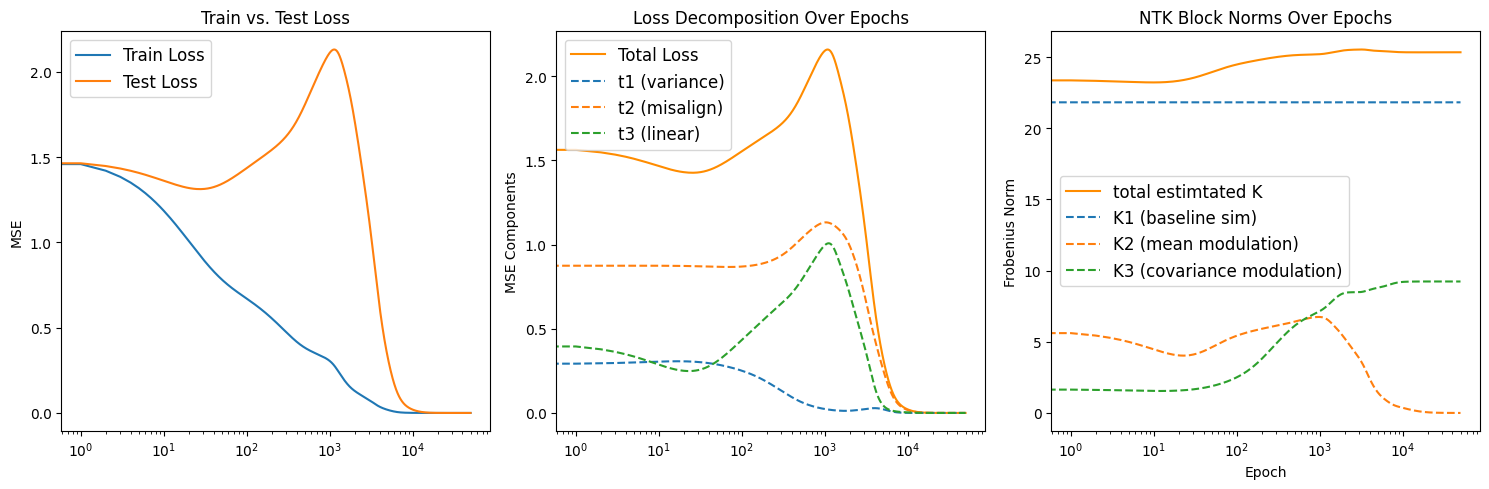

In [15]:
# Figure 4. Loss Decomposition.
D = 40
N = 2
alpha = 1
eps = 0.25
P = 120
alphas = [1]

epochs = 50000

ntk_interval = 200
vars_compute_interval = 10

all_tr_losses_eps = []
all_te_losses_eps = []
all_alignments, all_alignmentst = [], []

for alpha in alphas:
    def phi(z, eps = 0.25):
      return z + 0.5*eps*z**2
    
    def NN_func2(params,X, alpha, eps = 0.25):
      a, W = params
      D = W.shape[1]
      N = a.shape[0]
      h = W @ X
    
      f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts
    
      return f
    
    def target_fn(beta, X):
      return (X.T @ beta)**2/2.0
    
    X = random.normal(random.PRNGKey(0), (D,P))/ jnp.sqrt(D)
    Xt = random.normal(random.PRNGKey(1), (D,1000))/ jnp.sqrt(D)
    beta = random.normal(random.PRNGKey(2), (D,))
    
    y = target_fn(beta, X)
    yt = target_fn(beta,Xt)
    
    W = random.normal(random.PRNGKey(0), (N, D))
    
    a = random.normal(random.PRNGKey(0), (N, ))
    params = [a, W]
    
    eta = 0.5 * N / alpha**2
    lamb = 0
    opt_init, opt_update, get_params = optimizers.sgd(eta)
    
    opt_state = opt_init(params)
    loss_fn = jit(lambda p, X, y: jnp.mean( ( NN_func2(p, X,alpha, eps) - y )**2 ))
    reg_loss = jit(lambda p, X, y: loss_fn(p,X,y) + lamb / alpha * optimizers.l2_norm(p)**2 )
    
    grad_loss = jit(grad(reg_loss,0))
    
    tr_losses = []
    te_losses = []
    
    epochs_to_plot = []
    
    t1s, t2s, t3s, epochs_to_compute = [], [], [], []
    t1sm, t2sm, t3sm, ts_summ = [], [], [], []
    k1sm, k2sm, k3sm, ks_summ = [], [], [], []
    ks = []
    ts_sum = []
    
    ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=())
    
    for t in tqdm(range(epochs)):
        opt_state = opt_update(t, grad_loss(get_params(opt_state), X, y), opt_state)
        pars = get_params(opt_state)
        
        train_loss = loss_fn(pars, X, y)
        test_loss = loss_fn(pars, Xt, yt)
        tr_losses += [train_loss]
        te_losses += [test_loss]
        
        
        if t % vars_compute_interval == 0:
            W = pars[1] # 2 * 40
            A = W @ beta / D # 2
            M = W.T @ W / N # 40 * 40
            wbar = np.mean(W, axis=0) # 40
            v = wbar @ X # 120
            
            Gram = X.T @ X                # (P, P)  = x_i·x_j
            
            f1m = Gram                          # term1
            
            # term2: ε·(x_i·x_j)·(v_i + v_j)
            f2m = eps * (Gram * (v[:,None] + v[None,:]))
            
            # term3: ε²·(x_i·x_j)·( x_i^T M x_j )
            f3m = eps**2 * ( Gram * ((X.T @ M) @ X) )
            
            # ----- reduce to scalars by F‐norm -----
            k1m = np.linalg.norm(f1m, 'fro')
            k2m = np.linalg.norm(f2m, 'fro')
            k3m = np.linalg.norm(f3m, 'fro')
            k1sm.append(k1m)
            k2sm.append(k2m)
            k3sm.append(k3m)
            ks_summ.append(np.linalg.norm(f1m + f2m + f3m, 'fro'))
            
            # k = ntk_fn(X.T, None, pars)
            # ks.append(k)
            
            t1m = (alpha * eps/2.0 * 1.0/D * np.trace(M) - np.mean(beta**2)/2)**2
            t2m = (1/2) * np.mean( ( alpha*eps* M - np.outer(beta, beta) )**2 )
            t3m = alpha**2 * (1/D) * np.linalg.norm(np.mean(W, axis=0))**2
        
            t1sm.append(t1m)
            t2sm.append(t2m)
            t3sm.append(t3m)
            ts_summ.append(t1m + t2m + t3m)
        
            epochs_to_compute.append(t)

    all_tr_losses_eps += [tr_losses]
    all_te_losses_eps += [te_losses]
    
    T_compute = np.array(epochs_to_compute)
    
    t1sm_spline = make_interp_spline(T_compute, np.array(t1sm), k=3)
    t2sm_spline = make_interp_spline(T_compute, np.array(t2sm), k=3)
    t3sm_spline = make_interp_spline(T_compute, np.array(t3sm), k=3)
    
    k1sm_spline = make_interp_spline(T_compute, np.array(k1sm), k=3)
    k2sm_spline = make_interp_spline(T_compute, np.array(k2sm), k=3)
    k3sm_spline = make_interp_spline(T_compute, np.array(k3sm), k=3)
    # ks_spline = make_interp_spline(T_compute, np.array(ks), k=3)
    
    t1sm_smooth = t1sm_spline(np.arange(epochs))
    t2sm_smooth = t2sm_spline(np.arange(epochs))
    t3sm_smooth = t3sm_spline(np.arange(epochs))
    ts_summ_smooth = make_interp_spline(T_compute, np.array(ts_summ), k=3)(np.arange(epochs))
    
    k1sm_smooth = k1sm_spline(np.arange(epochs))
    k2sm_smooth = k2sm_spline(np.arange(epochs))
    k3sm_smooth = k3sm_spline(np.arange(epochs))
    # ks_smooth = ks_spline(np.arange(epochs))
    ks_summ_smooth = make_interp_spline(T_compute, np.array(ks_summ), k=3)(np.arange(epochs))
    
    tit = f'N={N}, P={P}, D={D}, eps={eps}, lr={round(eta, 2)}, alpha={round(alpha, 2)}, lamb={lamb}'
    # let's check if our decomp here with A,M is equiv to what BB wrote in current manuscript, bc i suspect that (rather than wbar' or M') is the prob
    
    def get_random_color():
      return np.random.rand(3,)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
    
    # ------------------
    # 1) Train/Test Loss
    # ------------------
    axes[0].plot(tr_losses, label='Train Loss')
    axes[0].plot(te_losses, label='Test Loss')
    axes[0].set_xscale('log')
    axes[0].set_ylabel('MSE')
    axes[0].legend(fontsize=12)
    axes[0].set_title('Train vs. Test Loss')
    
    # ------------------
    # 2) T-terms (t1, t2, t3)
    # ------------------
    axes[1].plot(ts_summ_smooth, label='Total Loss', color='darkorange')
    axes[1].plot(t1sm_smooth, label='t1 (variance)', linestyle='--')
    axes[1].plot(t2sm_smooth, label='t2 (misalign)', linestyle='--')
    axes[1].plot(t3sm_smooth, label='t3 (linear)', linestyle='--')
    axes[1].set_xscale('log')
    axes[1].set_ylabel('MSE Components')
    axes[1].legend(fontsize=12)
    axes[1].set_title('Loss Decomposition Over Epochs')
    
    # ------------------
    # 3) K-terms (k1, k2, k3 norms)
    # ------------------
    axes[2].plot(ks_summ_smooth, label='total estimtated K', color='darkorange')
    # axes[2].plot(ks_smooth, label='real K', color='r')
    axes[2].plot(k1sm_smooth, label='K1 (baseline sim)', linestyle='--')
    axes[2].plot(k2sm_smooth, label='K2 (mean modulation)', linestyle='--')
    axes[2].plot(k3sm_smooth, label='K3 (covariance modulation)', linestyle='--')
    axes[2].set_xscale('log')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Frobenius Norm')
    axes[2].legend(fontsize=12)
    axes[2].set_title('NTK Block Norms Over Epochs')
    
    plt.tight_layout()
    plt.savefig('ntkdecomp.pdf')
    plt.show()


AttributeError: 'list' object has no attribute 'shape'

In [41]:
# D: feature 40, P: data size 120, N: layer width 2
# X: 40 * 120 
# beta:
W = pars[1] # 2 * 40
A = W @ beta / D # 2
M = W.T @ W / N # 40 * 40
wbar = np.mean(W, axis=0) # 40
v = wbar @ X # 120

Gram = X.T @ X                # (P, P)  = x_i·x_j

k1m = Gram                          # term1

# term2: ε·(x_i·x_j)·(v_i + v_j)
k2m = eps * (Gram * (v[:,None] + v[None,:]))

# term3: ε²·(x_i·x_j)·( x_i^T M x_j )
k3m = eps**2 * ( Gram * ((X.T @ M) @ X) )

# ----- reduce to scalars by F‐norm -----
n1 = np.linalg.norm(k1m, 'fro')
n2 = np.linalg.norm(k2m, 'fro')
n3 = np.linalg.norm(k3m, 'fro')

In [42]:
n1+n2+n3

29.27206

In [37]:
def NN_func2(params,X):
    global alpha
    global eps

    a, W = params
    D = W.shape[1]
    N = a.shape[0]
    h = W @ X.T

    f = alpha * np.mean(phi(h,eps),axis=0) # w/o readouts
    return f


def phi(z, eps = 0.25):
    return z + 0.5*eps*z**2

ntk_fn = nt.empirical_ntk_fn(
    NN_func2, vmap_axes=0, trace_axes=())

In [38]:
K = ntk_fn(X.T, None, pars)

In [43]:
np.linalg.norm(k1m+k2m+k3m, 'fro')

23.396994

In [27]:
a = wbar @X
a.shape

(120,)

In [29]:
v[:,None].shape

(120, 1)